<a href="https://colab.research.google.com/github/adag21044/PoliticalTweetAnalyzer-/blob/main/PoliticalTweetAnalyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import re
import string
import pandas as pd
import nltk
import random
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from google.colab import files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [66]:
# İlk kez çalıştırıyorsanız, aşağıdaki satırları açın:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [67]:
# Sentiment Analyzer başlat
sia = SentimentIntensityAnalyzer()

In [68]:
def assign_label(tweet):
    sentiment_score = sia.polarity_scores(tweet)["compound"]
    if sentiment_score > 0.2:
        return 1  # Liberal (pozitif sentiment)
    elif sentiment_score < -0.2:
        return 0  # Muhafazakar (negatif sentiment)
    else:
        return random.choice([0, 1])  # Nötr tweetleri rastgele atama yerine, iki sınıfa da eşit dağıt

In [69]:
class TweetPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words("english"))
        self.lemmatizer = WordNetLemmatizer()

    def clean_tweet(self, tweet: str) -> str:
        if not isinstance(tweet, str):
            return ""

        # 1. Linkleri kaldır
        tweet = re.sub(r"http\S+", "", tweet)

        # 2. Mentions ve hashtagleri kaldır
        tweet = re.sub(r"@[A-Za-z0-9_]+", "", tweet)
        tweet = re.sub(r"#[A-Za-z0-9_]+", "", tweet)

        # 3. Noktalama işaretlerini kaldır
        tweet = tweet.translate(str.maketrans("", "", string.punctuation))

        # 4. Sayıları kaldır
        tweet = re.sub(r"\d+", "", tweet)

        # 5. Kelimeleri küçük harfe çevir
        tweet = tweet.lower()

        # 6. Stopwords kaldır
        words = word_tokenize(tweet)
        words = [word for word in words if word not in self.stop_words]

        # 7. Lemmatization uygula
        words = [self.lemmatizer.lemmatize(word) for word in words]
        words = [self.lemmatizer.lemmatize(word) for word in words]  # Lemmatization uygula

        return " ".join(words)

Yüklenen dosyanın sütunları: Index(['poll_id', 'pollster_id', 'pollster', 'sponsor_ids', 'sponsors',
       'display_name', 'pollster_rating_id', 'pollster_rating_name',
       'numeric_grade', 'pollscore', 'methodology', 'transparency_score',
       'state', 'start_date', 'end_date', 'sponsor_candidate_id',
       'sponsor_candidate', 'sponsor_candidate_party', 'question_id',
       'sample_size', 'population', 'subpopulation', 'population_full',
       'tracking', 'created_at', 'notes', 'url', 'source', 'internal',
       'partisan', 'race_id', 'cycle', 'office_type', 'seat_number',
       'seat_name', 'election_date', 'stage', 'nationwide_batch', 'dem', 'rep',
       'ind'],
      dtype='object')
İlk 5 temizlenmiş tweet:
      tweet  label cleaned_tweet
0   Emerson      1       emerson
1    YouGov      1        yougov
2  Monmouth      0      monmouth
3    Cygnal      1        cygnal
4    YouGov      0        yougov

Veri dağılımı:
label
1    313
0    303
Name: count, dtype: int64


<ipython-input-70-05677ec48833>:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=dataset.data["label"], palette="coolwarm")


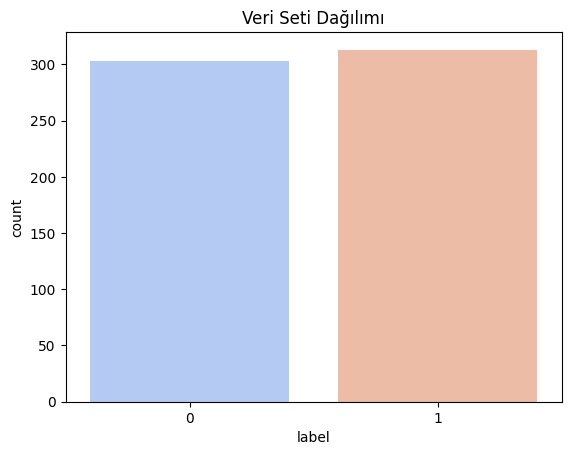

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.1


TF-IDF vektörleştirme uygulanıyor...
TF-IDF matris boyutu: (616, 71)
En önemli kelimeler: [('clarity', 0.015643144911501275), ('insight', 0.010211191634396134), ('noble', 0.009996714207720858), ('predictive', 0.009996714207720858), ('wpai', 0.0046291574895787405), ('poll', 0.003957375300926977), ('harrisxharris', 0.0034677372325840894), ('bullfinch', 0.003384401600413915), ('progress', 0.003308826927324652), ('data', 0.0027183860092908872)]
Word2Vec Modeli Eğitildi!


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.1

In [70]:
class TweetDataset:
    def __init__(self, file_paths):
        self.file_paths = file_paths
        self.data = self.load_data()

    def load_data(self):
        dataframes = []
        for file in self.file_paths:
            df = pd.read_csv(file)
            print("Yüklenen dosyanın sütunları:", df.columns)  # Sütunları göster

            # Metin içeren en uygun sütunu bul (dtype yerine içeriğe bakarak belirle)
            text_col = None
            for col in df.columns:
                if df[col].dtype == "object" and df[col].apply(lambda x: isinstance(x, str)).sum() > len(df) * 0.5:
                    text_col = col
                    break

            if text_col:
                df = df[[text_col]]
                df.columns = ["tweet"]  # Standartlaştır
                df["label"] = df["tweet"].apply(assign_label)
                dataframes.append(df)
            else:
                print(f"⚠️ Uygun metin sütunu bulunamadı: {file}. Lütfen tweet içeren bir CSV yükleyin!")
        return pd.concat(dataframes, ignore_index=True) if dataframes else pd.DataFrame()

    def preprocess_tweets(self):
        preprocessor = TweetPreprocessor()
        if "tweet" in self.data.columns:
            self.data["cleaned_tweet"] = self.data["tweet"].apply(preprocessor.clean_tweet)
        return self.data

    def vectorize_tweets(self):
        if "cleaned_tweet" in self.data.columns:
            vectorizer = TfidfVectorizer(max_features=5000)
            tfidf_matrix = vectorizer.fit_transform(self.data["cleaned_tweet"])
            return tfidf_matrix, vectorizer
        else:
            print("❌ Hata: Temizlenmiş tweetler bulunamadı.")
            return None, None

# Google Colab için Dosya Yükleme
if __name__ == "__main__":

    file_paths = ["/content/generic_ballot_polls.csv"]

    dataset = TweetDataset(file_paths)
    if dataset.data.empty:
        print("❌ Hata: Geçerli bir metin sütunu içermeyen bir CSV yüklendi. Lütfen içinde tweet olan bir veri seti yükleyin!")
    else:
        processed_data = dataset.preprocess_tweets()
        print("İlk 5 temizlenmiş tweet:")
        print(processed_data.head())

        print("\nVeri dağılımı:")
        print(dataset.data["label"].value_counts())
        sns.countplot(x=dataset.data["label"], palette="coolwarm")
        plt.title("Veri Seti Dağılımı")
        plt.show()


        print("\nTF-IDF vektörleştirme uygulanıyor...")
        tfidf_matrix, vectorizer = dataset.vectorize_tweets()
        if tfidf_matrix is not None:
            print(f"TF-IDF matris boyutu: {tfidf_matrix.shape}")

            dataset.data["label"] = dataset.data["label"].round().astype(int)


            # Mutual Information ile en önemli kelimeleri belirleme
            mi_scores = mutual_info_classif(tfidf_matrix, dataset.data["label"].astype(int), discrete_features=True)
            top_features = sorted(zip(vectorizer.get_feature_names_out(), mi_scores), key=lambda x: x[1], reverse=True)[:10]
            print("En önemli kelimeler:", top_features)

            # Word2Vec eğitme
            sentences = [tweet.split() for tweet in dataset.data["cleaned_tweet"]]
            w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)
            print("Word2Vec Modeli Eğitildi!")


